## Overview

Since we are now acquainted with the fundamentals of PyPSA (`01_toy_model_sgp`), as well as how we can model more complex system features (`02_toy_model_sgp_storage`), we can turn our attention to modelling a 24/7 carbon-free energy (CFE) scenario. 

To do so, we are going to model a system as illustrated below. Again, our system is quite similar to before, however we have now added an additional solar and wind plant, as well as a battery, and we have also created a new bus named *SGP CFE*. The reason we have created a separate subsystem for CFE is that it allows us to parameterise and track the procurement of CFE that serves the industrial load. This will become much clearer as we work through the example.

Here, we can see our system is quite similar to before, except that we have now added an onshore wind turbine, as well as an additional load to represent an industrial consumer.

<div>
<img src="../img/toy_model_sgp_cfe.png" width="500"/>
</div>

## Model build

In [1]:
import pypsa
import random
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Setup global variables and params

In [9]:
# define temporal resolution: let's do a 7-day simulation
timesteps = 24 * 7

<Axes: xlabel='snapshot'>

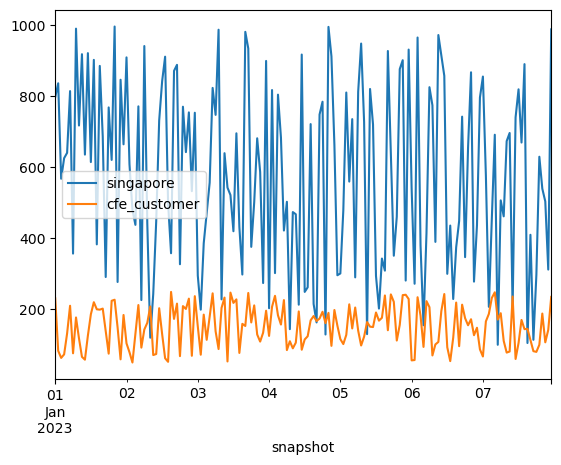

In [7]:
# build a synthetic demand for 24 hours
demand = \
    pd.DataFrame({
        'snapshot' : pd.date_range("2023-01-01", periods=timesteps, freq="H"),
        'unit' : 'MWh',
        'singapore' : random.sample(range(100, 1000), timesteps),
        'cfe_customer' : random.sample(range(50, 250), timesteps),
    }).set_index('snapshot')

demand[['singapore','cfe_customer']].plot()

<Axes: xlabel='snapshot'>

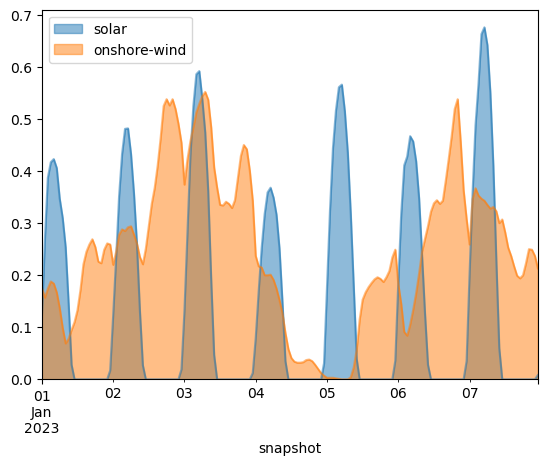

In [8]:
# load solar profile
#   - We are using a hypothetical profile downloaded from renewables ninja (https://www.renewables.ninja/)
#   - This curve tells us how much electricity we can generate (MWh) from a 1 MW solar farm

res_profiles = \
    pd.DataFrame({
        'snapshot' : pd.date_range("2023-01-01", periods=timesteps, freq="H"),
        'unit' : 'CF',
        'solar' : pd.read_csv('../data/ninja_pv_1.3838_103.7954_uncorrected.csv',skiprows=3).electricity.iloc[0:timesteps].values,
        'onshore-wind' : pd.read_csv('../data/ninja_wind_1.3672_103.8133_uncorrected.csv',skiprows=3).electricity.iloc[0:timesteps].values,
    }).set_index('snapshot')

res_profiles[['solar','onshore-wind']].plot.area(stacked=False)

### Step 2: Define system in dataframes

In [12]:
# Carriers
carriers = pd.DataFrame({
    'carrier' : ['solar','gas','onshore-wind'],
    'emissions' : [0, 10, 0],
    'nice_name' : ['Solar PV', 'Natural Gas', 'Onshore Wind'],
    'color' : ['yellow', 'grey', 'green'],
})

# Buses
buses = pd.DataFrame({
    'name' : ['SGP Grid', 'SGP CFE'],
    'x' : [103.851959, 104.851959],
    'y' : [1.290270, 1.390270],
})

# Generators
buses

,name,x,y
0,SGP Grid,103.851959,1.29027
1,SGP CFE,104.851959,1.39027


In [7]:
generators = 

,name,carrier,bus,capacity,marginal_cost,capital_cost,variable,extendable
0,sgp_solar,solar,Singapore,200,0,200,True,True
1,sgp_gas,gas,Singapore,150,100,250,False,True
2,sgp_onshore-wind,onshore-wind,Singapore,100,0,300,True,True


### Step 3: Construct PyPSA model

In [8]:
def construct_pypsa_model():

    # create network class
    network = pypsa.Network()

    # define our hourly timesteps (referred to as snapshots)
    network.set_snapshots(demand.index)

    # define carriers
    network.madd(
        'Carrier', # PyPSA component
        carriers['carrier'].to_list(),
        co2_emissions=carriers.set_index('carrier').emissions.to_dict(),
        nice_name=carriers.set_index('carrier').nice_name.to_dict(), # verbose names
        color=carriers.set_index('carrier').color.to_dict(), # colours for plotting
    )

    # define buses
    for i, row in buses.iterrows():

        network.add(
            "Bus",  # PyPSA component
            row['name'], # bus name
            x = row['x'], # longitude
            y = row['y'], # latitude
        )

    # define load curves
    for load_point in [i for i in demand.columns.to_list() if i != 'unit']:

        network.add(
                "Load", 
                load_point, 
                bus=buses['name'].iloc[0], 
                p_set=demand[load_point],
            )

    # generators (dispatch)
    for i, row in generators[ generators.variable == False].iterrows():
        network.add(
            'Generator', # PyPSA component
            row['name'], # generator name
            bus = row['bus'], # balancing zone
            carrier = row['carrier'],
            p_nom = row['capacity'], # starting capacity
            marginal_cost = row['marginal_cost'],
            capital_cost = row['capital_cost'],
            p_nom_extendable = row['extendable'], # extendable?
        )

    # generators (variable)
    for i, row in generators[ generators.variable == True].iterrows():
        network.add(
            'Generator', # PyPSA component
            row['name'], # generator name
            bus = row['bus'], # balancing zone
            carrier = row['carrier'],
            p_nom = row['capacity'], # starting capacity
            marginal_cost = row['marginal_cost'],
            capital_cost = row['capital_cost'],
            p_nom_extendable = row['extendable'], # extendable?
            p_max_pu = res_profiles[row['carrier']], # res profile
        )

    return network

### Step 4: Solve model

In [9]:
network = construct_pypsa_model()

network.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 76 primals, 171 duals
Objective: 5.85e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
72 rows, 51 cols, 156 nonzeros
72 rows, 51 cols, 156 nonzeros
Presolve : Reductions: rows 72(-99); columns 51(-25); elements 156(-123)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0750000000e+05 Pr: 24(5913) 0s
         51     5.8490990137e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 51
Objective value     :  5.8490990137e+05
HiGHS run time      :          0.00


('ok', 'optimal')

### Step (4): Explore our results

<Axes: xlabel='snapshot'>

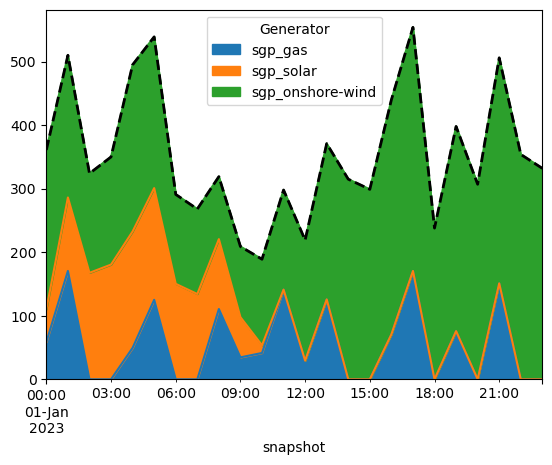

In [10]:
# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)

# dispatch by carrier
network.generators_t.p.plot.area(stacked=True,ax=ax)

# demand
network.loads_t.p.sum(axis=1).plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')

We can also get several statistics directly from PyPSA. Let's explore these:

In [11]:
# total dispatch by carrier
network.statistics.dispatch()

component  carrier     
Load       -              -8486.000000
Generator  Natural Gas     1355.419323
           Onshore Wind    5786.234684
           Solar PV        1344.345993
dtype: float64

In [12]:
# total curtailment by carrier
network.statistics.curtailment()

component  carrier     
Generator  Natural Gas       0.000000
           Onshore Wind    492.385225
           Solar PV          7.362720
dtype: float64

In [13]:
# energy balance by carrier and loads (i.e. input vs output)
network.statistics.energy_balance()

component  carrier       bus_carrier
Load       -             AC            -8486.000000
Generator  Natural Gas   AC             1355.419323
           Onshore Wind  AC             5786.234684
           Solar PV      AC             1344.345993
dtype: float64

In [14]:
# capacity expansion
network.statistics.expanded_capacity()

component  carrier     
Generator  Natural Gas       20.583710
           Onshore Wind    1325.339367
           Solar PV         233.101157
dtype: float64

### Scenario: constraint emissions
We can see in the results above that the model is dispatching quite a lot of gas while curtailing wind and solar resources. This happens because the model currently does not pay any attention to emissions. Let's see what happens if we constrain emissions to 10% of the baseline run.

In [15]:
# calculate emissions

total_emissions = (
    network.generators_t.p
    / network.generators.efficiency
    * network.generators.carrier.map(network.carriers.co2_emissions)
)

network = construct_pypsa_model()

network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=total_emissions.sum().sum() * 0.1,
)

# solve model again
network.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 76 primals, 172 duals
Objective: 6.63e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
73 rows, 51 cols, 180 nonzeros
73 rows, 51 cols, 180 nonzeros
Presolve : Reductions: rows 73(-99); columns 51(-25); elements 180(-123)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0750000000e+05 Pr: 24(9733) 0s
         35     6.6316062668e+05 Pr: 0(0); Du: 0(8.28818e-14) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 35
Objective value     :  6.6316062668e+05
HiGHS run time      :          0.00


('ok', 'optimal')

<Axes: xlabel='snapshot'>

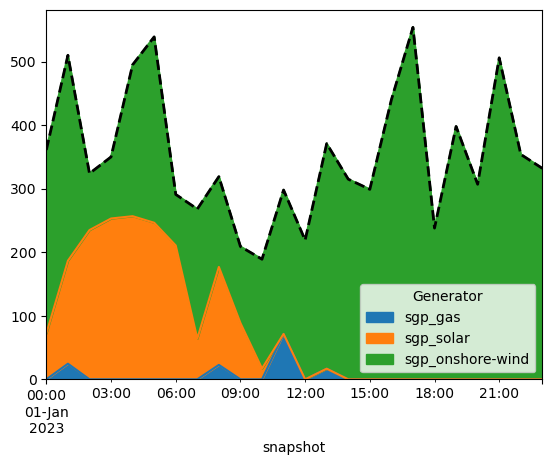

In [16]:
# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)

# dispatch by carrier
network.generators_t.p.plot.area(stacked=True,ax=ax)

# demand
network.loads_t.p.sum(axis=1).plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')

 We can now see the model is mainly utilising solar and wind. The gas power plant is turned on for a few hours around midday, but then switched off to meet the emissions constraint. However, this does require quite a bit of wind and solar capacity expansion, as shown below. 

In [17]:
# capacity expansion
network.statistics.expanded_capacity()

component  carrier     
Generator  Natural Gas      -78.542751
           Onshore Wind    1959.479554
           Solar PV         406.991275
dtype: float64

In [18]:
# energy balance by carrier and loads (i.e. input vs output)
network.statistics.energy_balance()

component  carrier       bus_carrier
Load       -             AC            -8486.000000
Generator  Natural Gas   AC              135.541932
           Onshore Wind  AC             6590.412921
           Solar PV      AC             1760.045147
dtype: float64

### Extension: Adding battery storage
Let's modify the system above slightly by adding a battery storage unit (below). This should allow the system to tap into the curtailed solar and wind resources, thus reducing the amount of renewable capacity we need to build. 

<div>
<img src="../img/toy_model_sgp_storage.png" width="500"/>
</div>

In [21]:
# construct network as before
network = construct_pypsa_model()

# add a battery component
network.add(
    "StorageUnit", # PyPSA component
    'sgp_battery', # name
    carrier='battery',
    bus=buses.loc[0]['name'], # Singapore bus
    p_nom=100, # initial capacity
    p_nom_extendable=True, # extendable?
    capital_cost=50, 
    marginal_cost=0,
    cyclic_state_of_charge=False,
    max_hours=6, # energy-to-power ratio
)

# solve model again
network.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 149 primals, 340 duals
Objective: 4.77e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
180 rows, 136 cols, 467 nonzeros
178 rows, 134 cols, 461 nonzeros
Presolve : Reductions: rows 178(-162); columns 134(-15); elements 461(-178)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.1250000000e+05 Pr: 24(9007) 0s
         99     4.7685350015e+05 Pr: 0(0); Du: 0(1.42109e-14) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 99
Objective value     :  4.7685350015e+05
HiGHS run time      :          0.00


('ok', 'optimal')

<Axes: xlabel='snapshot'>

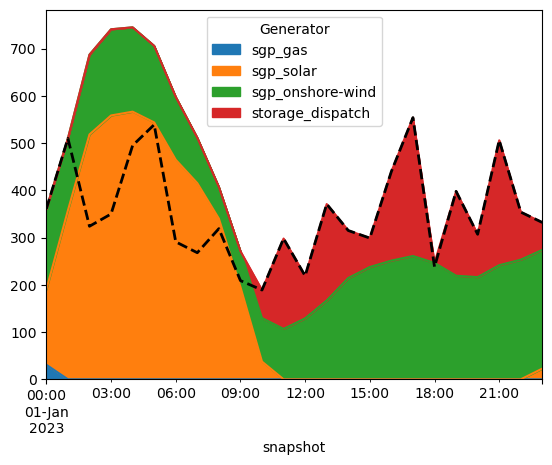

In [28]:
# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)

# dispatch by carrier
dispatch = (
    network.generators_t.p
        .assign( storage_dispatch = network.storage_units_t.p_dispatch['sgp_battery'] )
)

dispatch.plot.area(stacked=True,ax=ax)

# demand
network.loads_t.p.sum(axis=1).plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')

In [29]:
network.statistics.curtailment()

component    carrier     
Generator    Natural Gas     0.000000e+00
             Onshore Wind    2.842171e-14
             Solar PV        0.000000e+00
StorageUnit  battery         0.000000e+00
dtype: float64

In [30]:
network.statistics.energy_balance()

component    carrier       bus_carrier
Load         -             AC            -8.486000e+03
Generator    Natural Gas   AC             3.080915e+01
             Onshore Wind  AC             4.274597e+03
             Solar PV      AC             4.180594e+03
StorageUnit  battery       AC            -9.947598e-14
dtype: float64